In [92]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from pandas.tseries.offsets import MonthEnd
import seaborn as sns

plt.style.use("ggplot")
register_matplotlib_converters()

# Get head and tail of data
The datasets may not cover the same time period. We spatially average the data into the five planning areas and then check if the data cover the same time period

In [3]:
big_df = pd.read_csv("./input/all_data.csv", index_col=[0],
                     parse_dates=[0]).replace("-", np.nan).astype(float)
# Examine data from 2004 onwards due to availability of serotype data
big_df = big_df.loc[big_df.index >= "2004-01-01"]

big_df["dengue-sg-log"] = np.log(big_df["dengue-sg"] + 1.0)
big_df["population-sg-log"] = np.log(big_df["population-sg"])
data = {}
for colname in big_df.columns:
    n = big_df[colname].shape[0]
    data[colname] = {}
    res_string = colname
    for i in range(n):
        if not pd.isna(big_df[colname][i]):
            res_string += ";{}".format(big_df.index[i])
            data[colname]["start"] = big_df.index[i]
            break
    for i in range(n):
        j = n - 1 - i
        if not pd.isna(big_df[colname][j]):
            res_string += ";{}".format(big_df.index[j])
            data[colname]["end"] = big_df.index[j]
            break

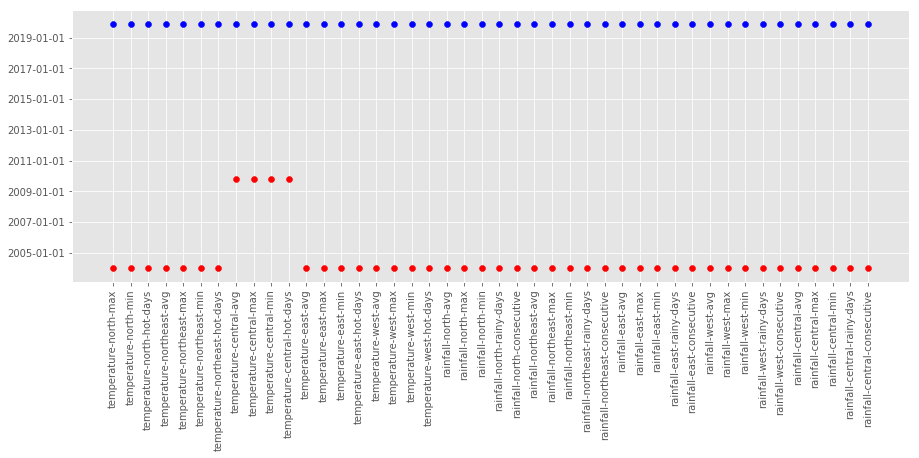

In [4]:
base_regions = {
    "temperature-north": ["temperature-admiralty", "temperature-khatib",
                          "temperature-sembawang"],
    "temperature-northeast": ["temperature-ang-mo-kio", "temperature-seletar",
                              "temperature-tai-seng"],
    "temperature-central": ["temperature-marina-barrage", "temperature-newton",
                            "temperature-sentosa-island"],
    "temperature-east": ["temperature-changi", "temperature-east-coast-parkway",
                         "temperature-pulau-ubin"],
    "temperature-west": ["temperature-boon-lay-east",
                         "temperature-choa-chu-kang-south",
                         "temperature-clementi", "temperature-jurong-island",
                         "temperature-pasir-panjang",
                         "temperature-semakau-island", "temperature-tengah",
                         "temperature-tuas-south"],
    "rainfall-north": ["rainfall-admiralty", "rainfall-admiralty-west",
                       "rainfall-khatib", "rainfall-kranji-reservoir",
                       "rainfall-lim-chu-kang", "rainfall-mandai",
                       "rainfall-sembawang", "rainfall-yishun"],
    "rainfall-northeast": ["rainfall-ang-mo-kio", "rainfall-buangkok",
                           "rainfall-lower-peirce-reservoir",
                           "rainfall-punggol", "rainfall-seletar",
                           "rainfall-serangoon", "rainfall-serangoon-north",
                           "rainfall-tai-seng",
                           "rainfall-upper-peirce-reservoir",
                           "rainfall-upper-thomson"],
    "rainfall-east": ["rainfall-chai-chee", "rainfall-changi",
                      "rainfall-east-coast-parkway",
                      "rainfall-pasir-ris-central", "rainfall-pasir-ris-west",
                      "rainfall-paya-lebar", "rainfall-pulau-ubin",
                      "rainfall-simei", "rainfall-tanjong-katong"],
    "rainfall-west": ["rainfall-boon-lay-east", "rainfall-boon-lay-west",
                      "rainfall-bukit-panjang",
                      "rainfall-choa-chu-kang-central",
                      "rainfall-choa-chu-kang-south",
                      "rainfall-choa-chu-kang-west", "rainfall-clementi",
                      "rainfall-jurong-east", "rainfall-jurong-north",
                      "rainfall-jurong-island", "rainfall-jurong-pier",
                      "rainfall-kent-ridge", "rainfall-pasir-panjang",
                      "rainfall-semakau-island", "rainfall-tengah",
                      "rainfall-tuas", "rainfall-tuas-south",
                      "rainfall-tuas-west"],
    "rainfall-central": ["rainfall-botanic-garden", "rainfall-bukit-timah",
                         "rainfall-buona-vista", "rainfall-dhoby-ghaut",
                         "rainfall-kampong-bahru",
                         "rainfall-macritchie-reservoir",
                         "rainfall-marina-barrage", "rainfall-marine-parade",
                         "rainfall-newton", "rainfall-nicoll-highway",
                         "rainfall-queenstown", "rainfall-sentosa-island",
                         "rainfall-somerset-road", "rainfall-tanjong-pagar",
                         "rainfall-toa-payoh", "rainfall-ulu-pandan",
                         "rainfall-whampoa"]
}
temperature_suffix = ["avg", "max", "min", "hot-days"]
rainfall_suffix = ["avg", "max", "min", "rainy-days", "consecutive"]
regions = {f"{k}-{suffix}": [f"{loc}-{suffix}" for loc in base_regions[k]]
           for k in base_regions
           for suffix in (temperature_suffix
                          if "temperature" in k else rainfall_suffix)}

region_head_tail = {}
for k in regions:
    region_head_tail[k] = {}
    region_head_tail[k]["start"] = min(data[loc]["start"] for loc in regions[k])
    region_head_tail[k]["end"] = max(data[loc]["end"] for loc in regions[k])

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
ax.yaxis.set_major_formatter(xfmt)
ax.yaxis_date()
ax.scatter(list(region_head_tail.keys())[1 :],
           [region_head_tail[k]["start"] for k in region_head_tail][1 :], c="r")
ax.scatter(list(region_head_tail.keys())[1 :],
           [region_head_tail[k]["end"] for k in region_head_tail][1 :], c="b")

plt.xticks(rotation=90)
plt.show()

## Spatial average across SG
Central temperature only starts from 2010 onwards. But central temperature is within 2 s.d. from SG temperature, so we will just use SG temperature since there's little deviation.

In [5]:
for region in regions:
    # mean(axis=1) accounts for nan and doesn't add count to it
    big_df[region] = big_df[regions[region]].mean(axis=1)
for suffix in temperature_suffix:
    big_df[f"temperature-sg-{suffix}"] = big_df[
        regions[f"temperature-north-{suffix}"] +
        regions[f"temperature-northeast-{suffix}"] +
        regions[f"temperature-central-{suffix}"] +
        regions[f"temperature-east-{suffix}"] +
        regions[f"temperature-west-{suffix}"]].mean(axis=1)
for suffix in rainfall_suffix:
    big_df[f"rainfall-sg-{suffix}"] = big_df[
        regions[f"rainfall-north-{suffix}"] +
        regions[f"rainfall-northeast-{suffix}"] +
        regions[f"rainfall-central-{suffix}"] +
        regions[f"rainfall-east-{suffix}"] +
        regions[f"rainfall-west-{suffix}"]].mean(axis=1)

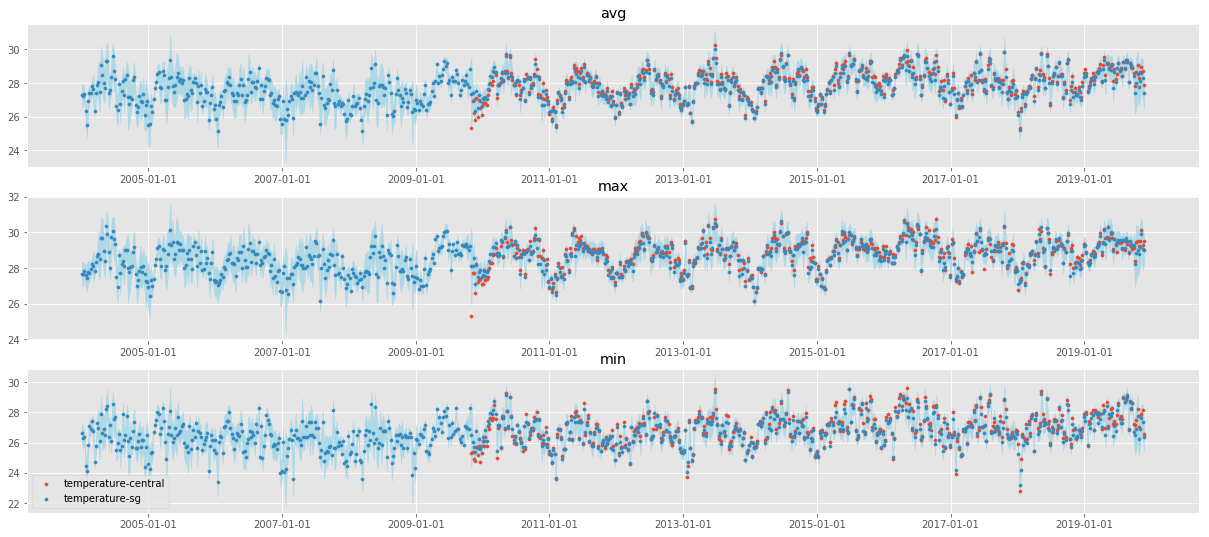

In [71]:
std = big_df[[f"temperature-{region}-avg"
              for region in ["north", "northeast", "east", "west",
                             "central"]]].std(axis=1)

f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(21)

xfmt = md.DateFormatter('%Y-%m-%d')
for ax, suffix in zip(ax, ["avg", "max", "min"]):
    ax.title.set_text(suffix)
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis_date()
    
    ax.fill_between(big_df.index, big_df[f"temperature-sg-{suffix}"] + 2 * std,
                    big_df[f"temperature-sg-{suffix}"] - 2 * std,
                    color="lightblue", edgecolor="")
    ax.scatter(big_df.index, big_df[f"temperature-central-{suffix}"], s=10,
               label="temperature-central")
    ax.scatter(big_df.index, big_df[f"temperature-sg-{suffix}"], s=10,
               label="temperature-sg")

plt.legend()
plt.show()

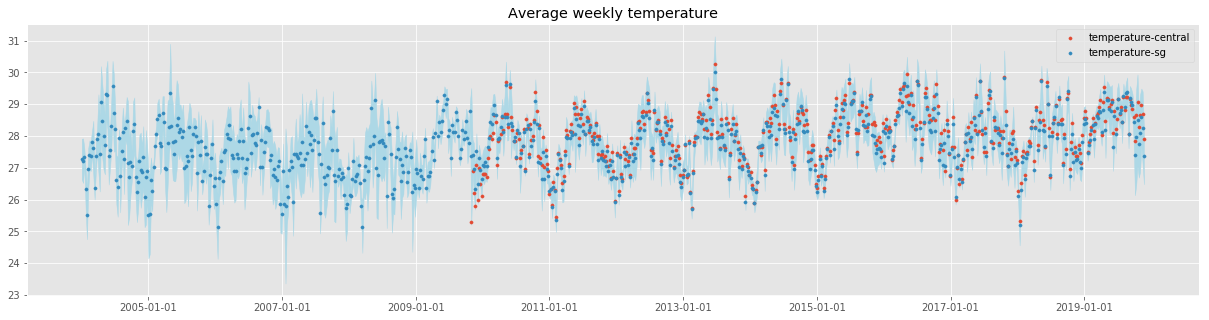

In [74]:
std = big_df[[f"temperature-{region}-avg"
              for region in ["north", "northeast", "east", "west",
                             "central"]]].std(axis=1)

f, ax = plt.subplots(1, 1)
f.set_figheight(5)
f.set_figwidth(21)

xfmt = md.DateFormatter('%Y-%m-%d')
suffix = "avg"
ax.title.set_text("Average weekly temperature")
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

ax.fill_between(big_df.index, big_df[f"temperature-sg-{suffix}"] + 2 * std,
                big_df[f"temperature-sg-{suffix}"] - 2 * std,
                color="lightblue", edgecolor="")
ax.scatter(big_df.index, big_df[f"temperature-central-{suffix}"], s=10,
           label="temperature-central")
ax.scatter(big_df.index, big_df[f"temperature-sg-{suffix}"], s=10,
           label="temperature-sg")

plt.legend()
plt.show()

# Temperature by month of year
Hotter temperatures have been found to result in higher levels of virus growth, so we compute the temperature difference from median monthly temperature

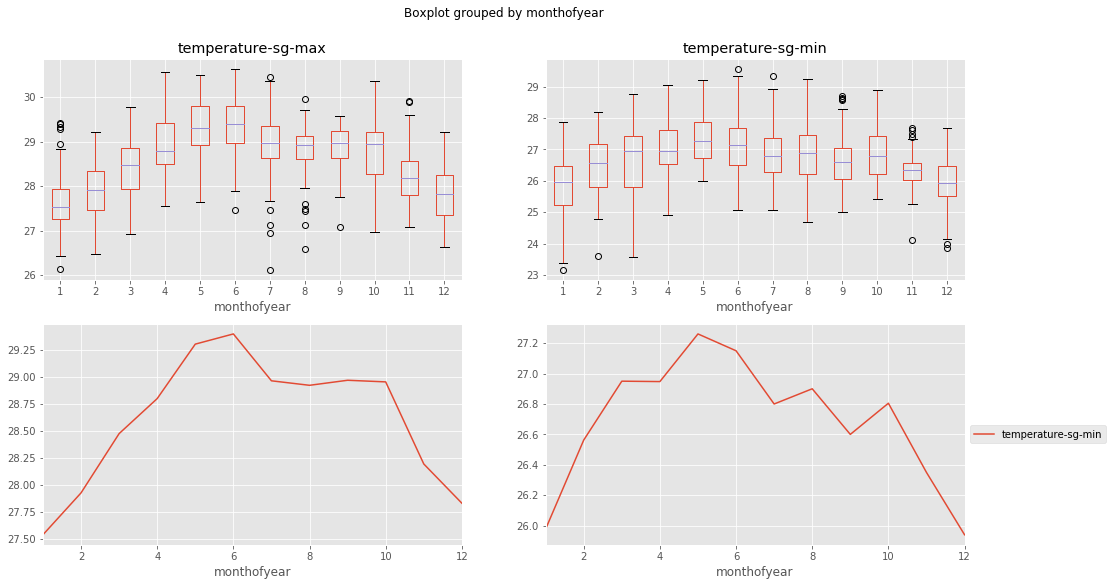

In [7]:
df_max_min = big_df[["temperature-sg-max", "temperature-sg-min"]].copy()
df_max_min["monthofyear"] = df_max_min.index.month

temp_max_median = df_max_min.groupby("monthofyear")["temperature-sg-max"].median()
temp_min_median = df_max_min.groupby("monthofyear")["temperature-sg-min"].median()

f, ax = plt.subplots(2, 2)
f.set_figheight(9)
f.set_figwidth(16)

df_max_min.boxplot("temperature-sg-max", "monthofyear", ax=ax[0][0])
df_max_min.boxplot("temperature-sg-min", "monthofyear", ax=ax[0][1])
temp_max_median.plot(ax=ax[1][0])
temp_min_median.plot(ax=ax[1][1])

plt.legend(loc=7, bbox_to_anchor=(1.35, 0.5))
plt.show()

####  Difference of max/min temperature from average max/min temperature by month
Hotter temperatures in the recent years

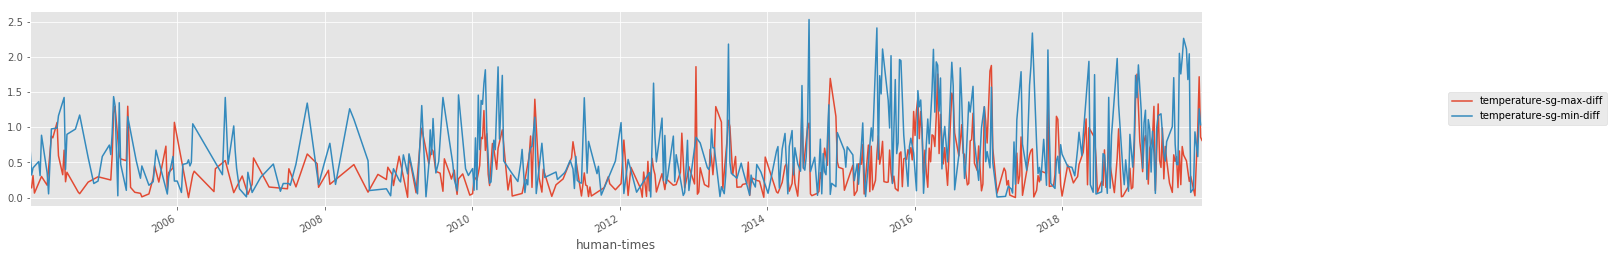

In [8]:
df_max_min["temperature-sg-max-diff"] = df_max_min["temperature-sg-max"] - df_max_min["monthofyear"].apply(lambda x: temp_max_median[x])
df_max_min["temperature-sg-min-diff"] = df_max_min["temperature-sg-min"] - df_max_min["monthofyear"].apply(lambda x: temp_min_median[x])

f, ax = plt.subplots(1, 1)
f.set_figheight(4)
f.set_figwidth(21)

df_max_min["temperature-sg-max-diff"][df_max_min["temperature-sg-max-diff"] > 0].plot(ax=ax)
df_max_min["temperature-sg-min-diff"][df_max_min["temperature-sg-min-diff"] > 0].plot(ax=ax)

plt.legend(loc=7, bbox_to_anchor=(1.35, 0.5))
plt.show()

# Absolute humidity
Absolute humidity has been found to have a stronger correlation to dengue cases than relative humidity, so we compute it from using relative humidity and average temperature.

In [9]:
humidity_df = pd.read_csv("./input/relative_humidity_monthly_mean.csv",
                          index_col=[0],
                          parse_dates=[0]).replace("-", np.nan).astype(float)
# Interpolate to weekly data to match frequency of dengue cases
humidity_df.index = humidity_df.index + MonthEnd()
humidity_df = humidity_df.reindex(pd.date_range(
    humidity_df.index[0], humidity_df.index[-1], freq="D")).interpolate()

humidity_df["T2"] = 7.5 * big_df["temperature-sg-avg"] / (237.7 + big_df["temperature-sg-avg"])
humidity_df["Es"] = 6.11 * np.power(10, humidity_df["T2"])
humidity_df["E"] = humidity_df["mean_rh"] * humidity_df["Es"] / 100
humidity_df["Td"] = (-430.22 + 237.7 * np.log(humidity_df["E"])) / (-np.log(humidity_df["E"]) + 19.08)
humidity_df["T1"] = 7.5 * humidity_df["Td"] / (237.7 + humidity_df["Td"])
humidity_df["mean_ah"] = 1000 * (6.11 * np.power(10, humidity_df["T1"]) * 100) / (
    (big_df["temperature-sg-avg"] + 273.16) * 461.5)
humidity_df.reindex(big_df.index).head()

,mean_rh,T2,Es,E,Td,T1,mean_ah
human-times,,,,,,,
2004-01-03,87.151613,0.772007,36.144981,31.500934,24.942388,0.712253,22.718114
2004-01-10,87.038710,0.770737,36.039455,31.368276,24.871493,0.710421,22.626212
2004-01-17,86.925806,0.773911,36.303776,31.557350,24.972458,0.713030,22.753119
2004-01-24,86.812903,0.747799,34.185325,29.677273,23.944094,0.686355,21.470854
2004-01-31,86.700000,0.727277,32.607556,28.270751,23.136896,0.665269,20.508088


# Seasonality
Some underlying causes of dengue cases have seasonality characteristics, we extract them using the Holt-Winters model.

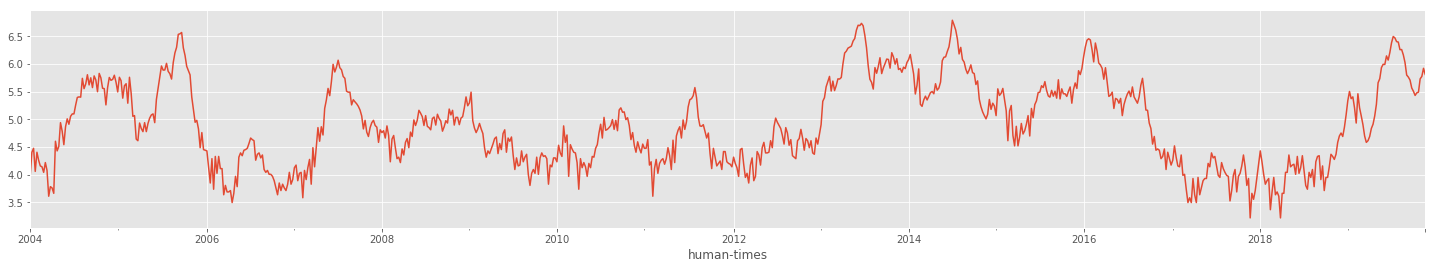

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, HoltWintersResults

data = big_df["dengue-sg-log"]
data.plot(figsize=(25, 4))

In [11]:
# Use only training data so we can apply seasonality with time lead without data
# leakage
split_timestamp = data.index[len(data.index) * 7 // 10 + 1]
print("Train/test split timestamp: ", split_timestamp)
train_years = data.index <= split_timestamp
model = ExponentialSmoothing(data.loc[train_years], seasonal_periods=52,
                             trend="add", seasonal="add", freq="7D")
fit = model.fit(use_boxcox=True)

Train/test split timestamp:  2015-02-28 00:00:00


C:\LYer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


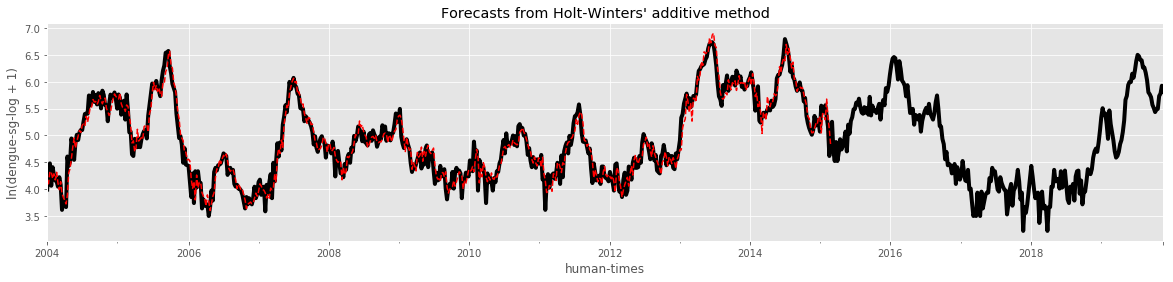

In [60]:
ax = data.plot(figsize=(20, 4), c="k", lw=4,
               title="Forecasts from Holt-Winters' additive method" )
ax.set_ylabel("ln(dengue-sg-log + 1)")
ax.set_xlabel("Year")

fit.fittedvalues.plot(ax=ax, style="--", color="r")

plt.show()

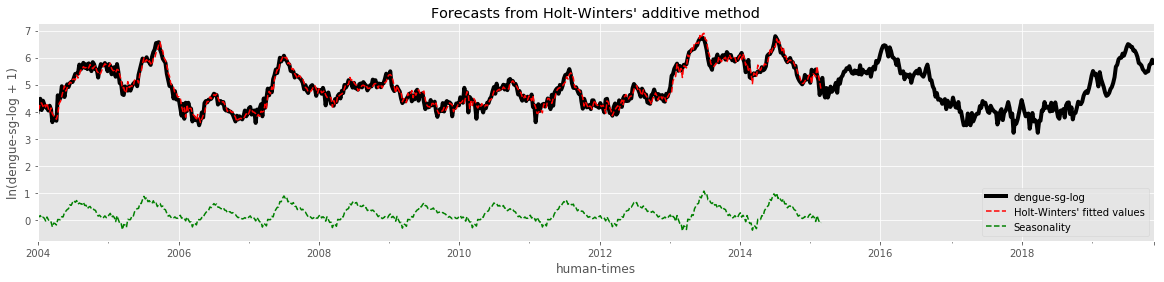

In [68]:
ax = data.plot(figsize=(20, 4), color="k", lw=4, title="Forecasts from Holt-Winters' additive method" )
ax.set_ylabel("ln(dengue-sg-log + 1)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="r", label="Holt-Winters' fitted values")

fit.season.plot(ax=ax, style="--", color="g", label="Seasonality")

plt.legend()
plt.show()

#### Use median value as the underlying seasonality

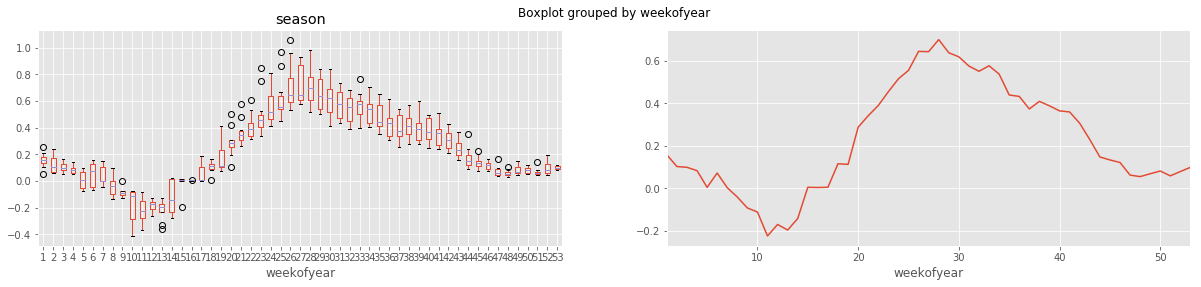

In [24]:
f, ax = plt.subplots(1, 2)
f.set_figheight(4)
f.set_figwidth(20)

season_df = pd.DataFrame()
season_df["season"] = fit.season
season_df["weekofyear"] = season_df.index.to_series().dt.weekofyear

season_median = season_df.groupby("weekofyear")["season"].median()

big_df["weekofyear"] = big_df.index.to_series().dt.weekofyear
big_df["hw-season-repeat"] = big_df["weekofyear"].apply(lambda x: season_median[x])

season_df.boxplot("season", "weekofyear", return_type="both", figsize=(16, 5), ax=ax[0])
season_median.plot(ax=ax[1])

plt.show()

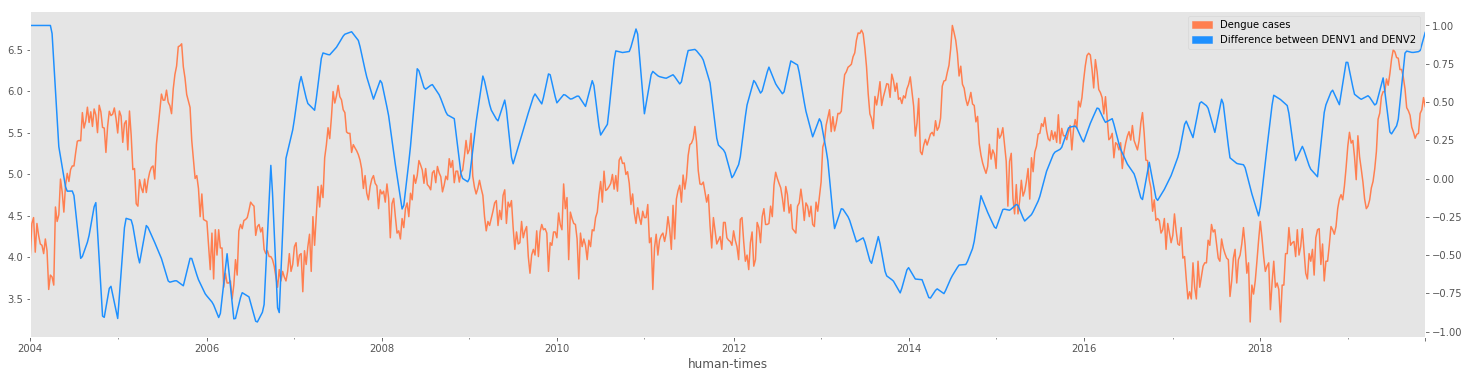

In [104]:
sero_df = pd.read_csv("./input/serotype.csv", index_col=[0], parse_dates=[0]).replace("-", np.nan).astype(float)

sero_df["denv-diff"] = sero_df["DENV2"] - sero_df["DENV1"]
sero_df["denv-diff-norm"] = sero_df["denv-diff"] / 100
sero_df = sero_df.reindex(pd.date_range(start="2004-01-01", end="2019-12-31")).interpolate()
sero_df = sero_df.reindex(big_df.index)

f, ax = plt.subplots(figsize=(25, 6))
ax2 = ax.twinx()
big_df["dengue-sg-log"].plot(ax=ax, c="coral", label="Dengue cases")
sero_df["denv-diff-norm"].plot(ax=ax2, c="dodgerblue", label="Difference between DENV1 and DENV2")
ax.grid(False)
ax2.grid(False)

red_patch = mpatches.Patch(color="coral", label="Dengue cases")
blue_patch = mpatches.Patch(color="dodgerblue", label="Difference between DENV1 and DENV2")

plt.legend(handles=[red_patch, blue_patch])

Spikes in dengues cases occurring with a change in serotype

In [51]:
# Serotype appears to have a 8-year cycle
big_df["year-mod-8"] = (big_df.index.year - 2004) % 8
big_df["temperature-sg-max-diff"] = df_max_min["temperature-sg-max-diff"]
big_df["temperature-sg-min-diff"] = df_max_min["temperature-sg-min-diff"]
input_df = big_df[["dengue-sg-log", "population-sg-log",
                   "temperature-sg-avg", "temperature-sg-max", "temperature-sg-min", "temperature-sg-hot-days",
                   "temperature-sg-max-diff", "temperature-sg-min-diff",
                   "rainfall-north-avg", "rainfall-northeast-avg", "rainfall-east-avg", "rainfall-west-avg",
                   "rainfall-central-avg", "rainfall-sg-avg",
                   "rainfall-north-max", "rainfall-northeast-max", "rainfall-east-max", "rainfall-west-max",
                   "rainfall-central-max", "rainfall-sg-max",
                   "rainfall-north-min", "rainfall-northeast-min", "rainfall-east-min", "rainfall-west-min",
                   "rainfall-central-min", "rainfall-sg-min",
                   "rainfall-north-rainy-days", "rainfall-northeast-rainy-days", "rainfall-east-rainy-days",
                   "rainfall-west-rainy-days", "rainfall-central-rainy-days", "rainfall-sg-rainy-days",
                   "rainfall-north-consecutive", "rainfall-northeast-consecutive", "rainfall-east-consecutive",
                   "rainfall-west-consecutive", "rainfall-central-consecutive", "rainfall-sg-consecutive"]].copy()
input_df["rel-humidity-avg"] = humidity_df["mean_rh"]
input_df["abs-humidity-avg"] = humidity_df["mean_ah"]
input_df["hw-season-repeat"] = big_df["hw-season-repeat"]
input_df["year-mod-8"] = big_df["year-mod-8"]
input_df["denv-diff-norm"] = sero_df["denv-diff-norm"]

input_df.to_csv("./output/input_data.csv")

In [52]:
df = pd.read_csv("./output/input_data.csv", index_col=[0], parse_dates=[0]).replace("-", np.nan).astype(float)
df.head()

,dengue-sg-log,population-sg-log,temperature-sg-avg,temperature-sg-max,temperature-sg-min,temperature-sg-hot-days,temperature-sg-max-diff,temperature-sg-min-diff,rainfall-north-avg,rainfall-northeast-avg,...,rainfall-northeast-consecutive,rainfall-east-consecutive,rainfall-west-consecutive,rainfall-central-consecutive,rainfall-sg-consecutive,rel-humidity-avg,abs-humidity-avg,hw-season-repeat,year-mod-8,denv-diff-norm
human-times,,,,,,,,,,,,,,,,,,,,,
2004-01-03,3.988984,15.242626,27.275,27.675,26.65,0.25,0.138636,0.672222,0.100000,0.18,...,0.6,0.75,1.428571,1.000000,1.08,87.151613,22.718114,0.158179,0.0,1.0
2004-01-10,4.406719,15.242626,27.225,27.675,26.30,0.50,0.138636,0.322222,2.300000,2.30,...,2.0,1.75,5.571429,3.000000,3.28,87.038710,22.626212,0.102802,0.0,1.0
2004-01-17,4.477337,15.242626,27.350,27.850,26.40,0.50,0.313636,0.422222,1.533333,4.26,...,1.0,1.25,1.142857,1.333333,1.16,86.925806,22.753119,0.099032,0.0,1.0
2004-01-24,4.060443,15.242626,26.325,27.600,24.45,0.25,0.063636,-1.527778,30.233333,43.04,...,2.4,2.00,2.714286,2.666667,2.48,86.812903,21.470854,0.083466,0.0,1.0
2004-01-31,4.406719,15.242626,25.525,27.450,24.15,0.00,-0.086364,-1.827778,15.666667,20.02,...,5.0,5.00,5.285714,5.000000,5.12,86.700000,20.508088,0.004530,0.0,1.0


In [53]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

# Exploratory data analysis
Plot correlations with lagged values to estimate the number lag weeks to use for feature engineering

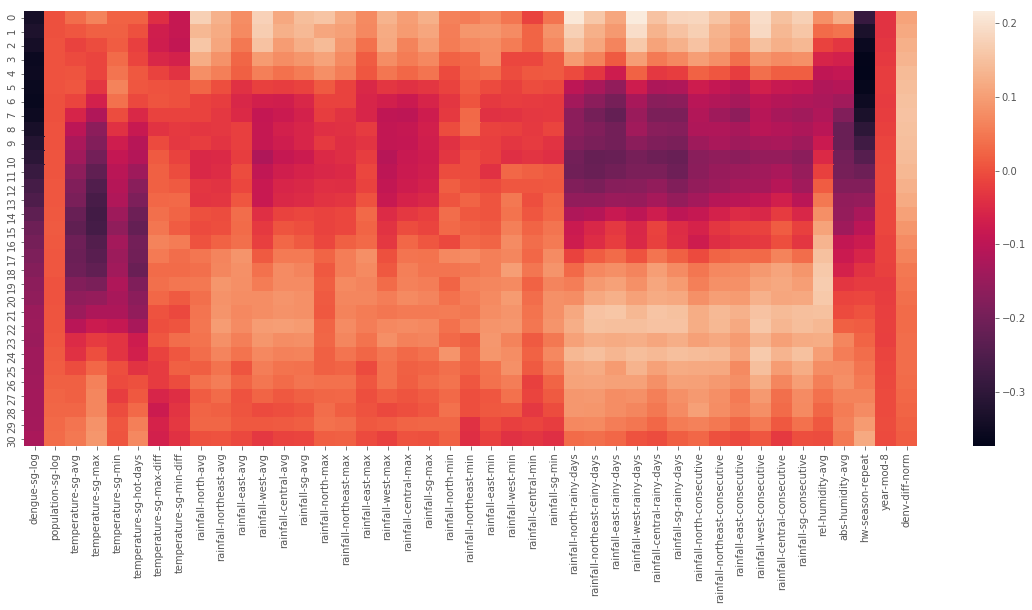

In [54]:
lags = np.arange(31)
lagged_df = pd.DataFrame()
for colname in df.columns:
    lagged_df[colname] = [crosscorr(df["dengue-sg-log"].shift(-8) - df["dengue-sg-log"], df[colname], lag) for lag in lags]

f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(lagged_df, ax=ax)

Model had difficulty in predicting the upstroke in validation dataset, look at correlation in validation dataset to construct features to use

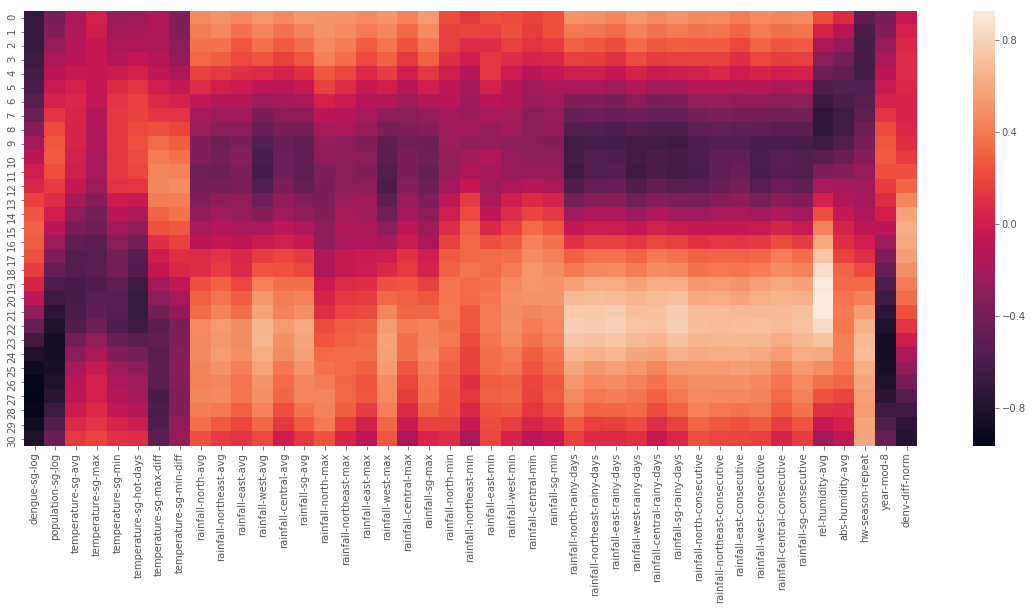

In [55]:
lagged_df = pd.DataFrame()
for colname in df.columns:
    lagged_df[colname] = [crosscorr(df.loc[df.index >= "2018-09-28"]["dengue-sg-log"].shift(-8) -
                                    df.loc[df.index >= "2018-09-28"]["dengue-sg-log"],
                                    df.loc[df.index >= "2018-09-28"][colname], lag) for lag in lags]

f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(lagged_df, ax=ax)